# 100 - Logistic Regression with IRIS and pytorch

First steps with [pytorch](http://pytorch.org/) and [Iris](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) dataset.

**Note:** install [tqdm](https://pypi.python.org/pypi/tqdm) if not installed: ``!pip install tqdm``

In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
from pylab import plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
print("torch", torch.__version__)
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelBinarizer

torch 0.4.0


In [2]:
X, Y = load_iris(return_X_y=True)
X = X.astype("float32")
X.shape, Y.shape

((150, 4), (150,))

In [3]:
ftrain = np.arange(X.shape[0]) % 4 != 0
Xtrain, Ytrain = X[ftrain, :], Y[ftrain]
Xtest, Ytest = X[~ftrain, :], Y[~ftrain]
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((112, 4), (112,), (38, 4), (38,))

In [4]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
N_EPOCHS = 2000

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 3)
    
    def forward(self, x):
        x = self.fc1(x)
        return F.log_softmax(x, dim=-1)

In [6]:
model = Net()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()

In [7]:
Xtrain_ = Variable(torch.from_numpy(Xtrain))
Xtest_ = Variable(torch.from_numpy(Xtest))
Ytrain_ = Variable(torch.from_numpy(Ytrain.astype(np.int64)))
Ytest_ = Variable(torch.from_numpy(Ytest.astype(np.int64)))
perfs = []
for t in range(1, N_EPOCHS + 1):
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()
    
    # Forward pass: compute predicted y by passing x to the model.
    Ypred = model(Xtrain_)

    # Compute and print loss.
    loss = loss_fn(Ypred , Ytrain_)

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    Ypred_test = model(Xtest_)
    loss_test = loss_fn(Ypred_test, Ytest_)
    pred = Ypred_test.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    accuracy = pred.eq(Ytest_.data.view_as(pred)).cpu().sum().item() / Ytest.size
    perfs.append([t, loss.data.item(), loss_test.data.item(), accuracy])

Last accuracy 0.947


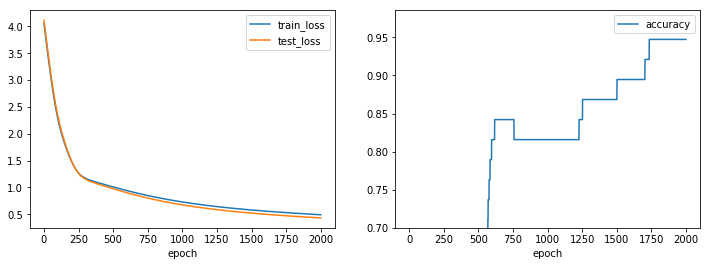

In [8]:
df_perfs = pd.DataFrame(perfs, columns=["epoch", "train_loss", "test_loss", "accuracy"]).set_index("epoch")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
print("Last accuracy %.3f" % df_perfs.accuracy.iloc[-1])
df_perfs[["train_loss", "test_loss"]].plot(ax=ax1);
df_perfs[["accuracy"]].plot(ax=ax2);
plt.ylim(ymin=0.7);